<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session4_attemp2b/3_aug_lr_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skeleton code


### Import Libraries


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

### Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(fill=(0,),degrees=(-7,7)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

### Dataset and creating train/ test split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader arguments and test/ train dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

In [5]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1)
        )  # ip = 28 | op = 26 | RF = 

        # CONVOLUTION BLOCK 
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(0.1)
        ) # ip = 26 | op = 24 | RF = 

        # TRANSITION BLOCK 
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=18, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
        ) # ip = 24 | op = 24 | RF = 
        self.pool1 = nn.MaxPool2d(2, 2) # ip = 24 | op = 12 | RF =

        # CONVOLUTION BLOCK 
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(0.1)
        ) # ip = 12 | op = 10 | RF = 

        # CONVOLUTION BLOCK 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)
        ) # ip = 10 | op = 8 | RF =

        # CONVOLUTION BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # ip = 8 | op = 6 | RF = 

        # GAP layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # ip = | op = | RF = 

        self.transblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # ip = 4 | op = 4 | RF = 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.transblock2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model parameters

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           1,728
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 18, 24, 24]             432
             ReLU-10           [-1, 18, 24, 24]               0
        MaxPool2d-11           [-1, 18, 12, 12]               0
           Conv2d-12           [-1, 14, 10, 10]           2,268

### Training and testing

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### Train and test our model (step size 6)

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08946993947029114 Batch_id=468 Accuracy=86.49: 100%|██████████| 469/469 [00:25<00:00, 18.68it/s]



Test set: Average loss: 0.1148, Accuracy: 9684/10000 (96.84%)

EPOCH: 1


Loss=0.038848716765642166 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]



Test set: Average loss: 0.0852, Accuracy: 9755/10000 (97.55%)

EPOCH: 2


Loss=0.03956156224012375 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.0508, Accuracy: 9843/10000 (98.43%)

EPOCH: 3


Loss=0.05591133236885071 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]



Test set: Average loss: 0.0344, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.03617781773209572 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]



Test set: Average loss: 0.0323, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.04627247154712677 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]



Test set: Average loss: 0.0350, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.012350340373814106 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]



Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.02868334949016571 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]



Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.04559938982129097 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.012133389711380005 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.0180103350430727 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:19<00:00, 24.07it/s]



Test set: Average loss: 0.0239, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.03255636617541313 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.34it/s]



Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.07986412197351456 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]



Test set: Average loss: 0.0229, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.03003617562353611 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.013152089901268482 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)




##### Plotting

Text(0.5, 1.0, 'Test Accuracy')

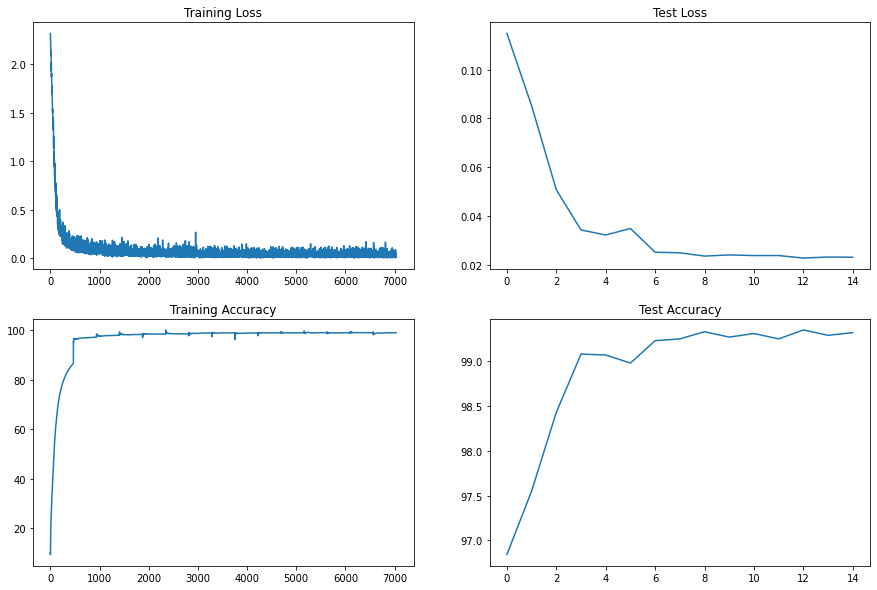

In [9]:
import numpy as np
fig, axs = plt.subplots(2,2,figsize=(15,10))
#train_losses=plt.plot(list(range(len(train_loss))),train_loss.cpu().detach().numpy(),color="r",label="Train "+typ)
#print (train_losses)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Train and test (step size 8)

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.09646139293909073 Batch_id=468 Accuracy=85.89: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.0992, Accuracy: 9734/10000 (97.34%)

EPOCH: 1


Loss=0.06489252299070358 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]



Test set: Average loss: 0.0835, Accuracy: 9758/10000 (97.58%)

EPOCH: 2


Loss=0.07513610273599625 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]



Test set: Average loss: 0.0460, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.0742548257112503 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0470, Accuracy: 9854/10000 (98.54%)

EPOCH: 4


Loss=0.06875868886709213 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0327, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.07578781247138977 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]



Test set: Average loss: 0.0297, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.07467625290155411 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]



Test set: Average loss: 0.0283, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.04572899267077446 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0324, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.014231320470571518 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.43it/s]



Test set: Average loss: 0.0256, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.05878916010260582 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]



Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.02261604554951191 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]



Test set: Average loss: 0.0244, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.04799993708729744 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.02629520744085312 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]



Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.055068645626306534 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.034771207720041275 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0226, Accuracy: 9926/10000 (99.26%)



##### Plotting

Text(0.5, 1.0, 'Test Accuracy')

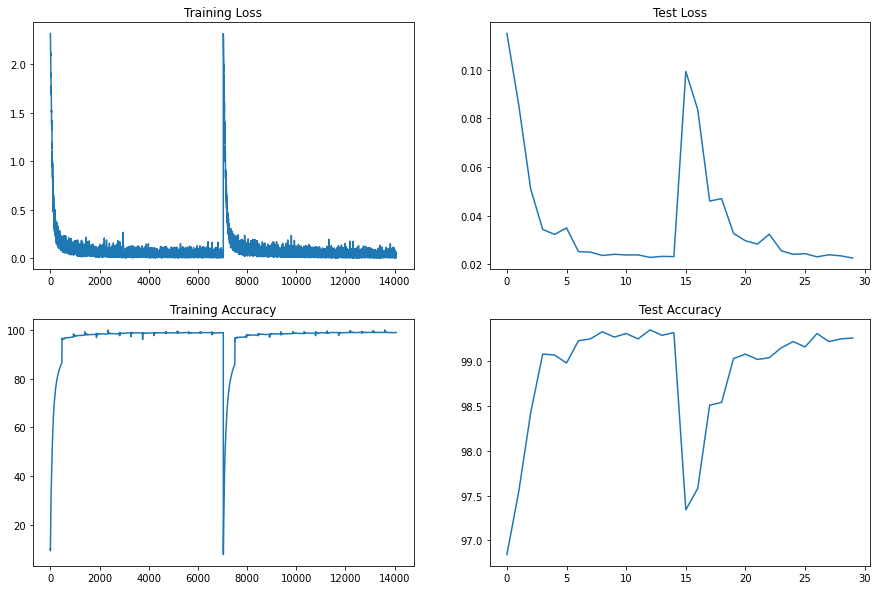

In [11]:
import numpy as np
fig, axs = plt.subplots(2,2,figsize=(15,10))
#train_losses=plt.plot(list(range(len(train_loss))),train_loss.cpu().detach().numpy(),color="r",label="Train "+typ)
#print (train_losses)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Train and test (step size 10)

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1514820009469986 Batch_id=468 Accuracy=83.65: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]



Test set: Average loss: 0.2146, Accuracy: 9384/10000 (93.84%)

EPOCH: 1


Loss=0.04479261860251427 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:19<00:00, 24.26it/s]



Test set: Average loss: 0.0692, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.09571558982133865 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]



Test set: Average loss: 0.0499, Accuracy: 9852/10000 (98.52%)

EPOCH: 3


Loss=0.03829720988869667 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]



Test set: Average loss: 0.0328, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.05129968747496605 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0348, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.03355697914958 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]



Test set: Average loss: 0.0279, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.03408628702163696 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0312, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.023006325587630272 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.01897481083869934 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:18<00:00, 25.85it/s]



Test set: Average loss: 0.0325, Accuracy: 9895/10000 (98.95%)

EPOCH: 9


Loss=0.028833480551838875 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]



Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.0354076623916626 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]



Test set: Average loss: 0.0219, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.028231890872120857 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]



Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.02416353113949299 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:19<00:00, 24.20it/s]



Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.04296247661113739 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.032484158873558044 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)



##### plotting

Text(0.5, 1.0, 'Test Accuracy')

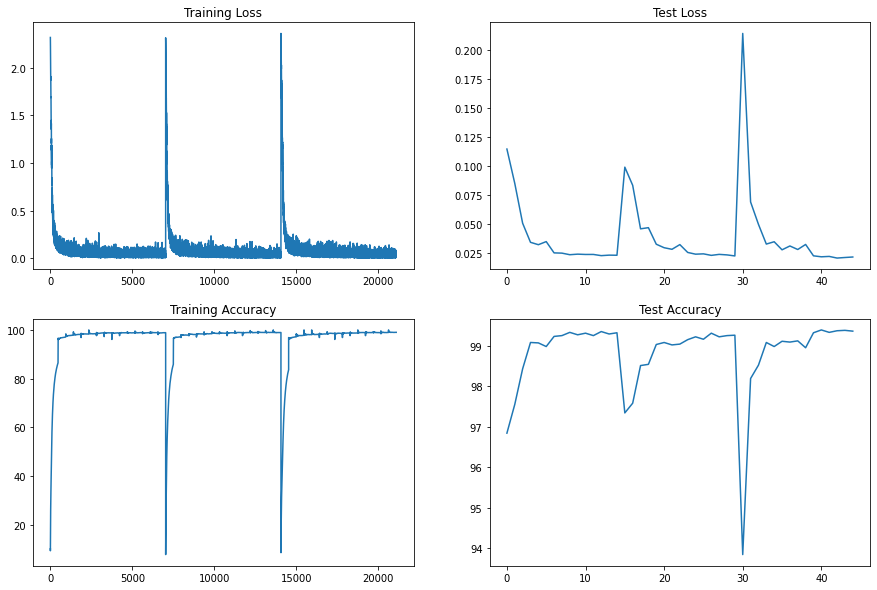

In [13]:
import numpy as np
fig, axs = plt.subplots(2,2,figsize=(15,10))
#train_losses=plt.plot(list(range(len(train_loss))),train_loss.cpu().detach().numpy(),color="r",label="Train "+typ)
#print (train_losses)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")